In [62]:
!pip install matplotlib numpy pandas seaborn scikit-learn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

Data Cleaning

In [63]:
df = pd.read_csv("./Spotify Most Streamed Songs.csv")
df

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,A,Major,55,58,72,11,0,11,15,https://i.scdn.co/image/ab67616d0000b273e787cf...
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,A,Minor,65,23,80,14,63,11,6,https://i.scdn.co/image/ab67616d0000b273ab5c9c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,...,A,Major,60,24,39,57,0,8,3,https://i.scdn.co/image/ab67616d0000b2730f5397...
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,...,F#,Major,42,7,24,83,1,12,6,https://i.scdn.co/image/ab67616d0000b273e0b60c...
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,...,C#,Major,80,81,67,4,0,8,6,Not Found
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,...,C#,Major,82,67,77,8,0,12,5,Not Found


In [64]:
# Rename field to specify data
df = df.rename(columns={'streams': 'spotify_streams'})

# Remove irrelevant fields
df = df.drop('cover_url', axis=1)

# Index dataframe by track name and artist
df = df.set_index(['track_name', 'artist(s)_name'])

# Group related fields where appropriate
date_cols = ['released_year', 'released_month', 'released_day']
spotify_col = ['in_spotify_playlists', 'in_spotify_charts', 'spotify_streams']
apple_col = ['in_apple_playlists', 'in_apple_charts']
deezer_col = ['in_deezer_playlists', 'in_deezer_charts']
playlists_col = ['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']
charts_col = ['in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_shazam_charts']
musical_info_col = ['bpm', 'key', 'mode']

# Convert mode to binary
df['mode'] = df['mode'].map({'Major': 0, 'Minor': 1})
mode_dict = {0: 'Major', 1: 'Minor'}

# Convert nominal key values to numerical values
df["key"] = df['key'].map({
    'A': 0, 'A#': 1, 'B': 2, 'C': 3,
    'C#': 4, 'D': 5, 'D#': 6, 'E': 7,
    'F': 8, 'F#': 9, 'G': 10, 'G#': 11,
    np.nan: np.nan
})
key_dict = {
    0 : 'A', 1 : 'A#', 2 : 'B', 3 : 'C',
    4 : 'C#', 5 : 'D', 6 : 'D#', 7 : 'E',
    8 : 'F', 9 : 'F#', 10 : 'G', 11 : 'G#',
    np.nan : np.nan
}

# Handle NaN or inappropriate values
df = df.replace('BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3', np.nan)
df['spotify_streams'] = pd.to_numeric(df['spotify_streams'].str.replace(',',''), errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'].str.replace(',',''), errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'].str.replace(',',''), errors='coerce')

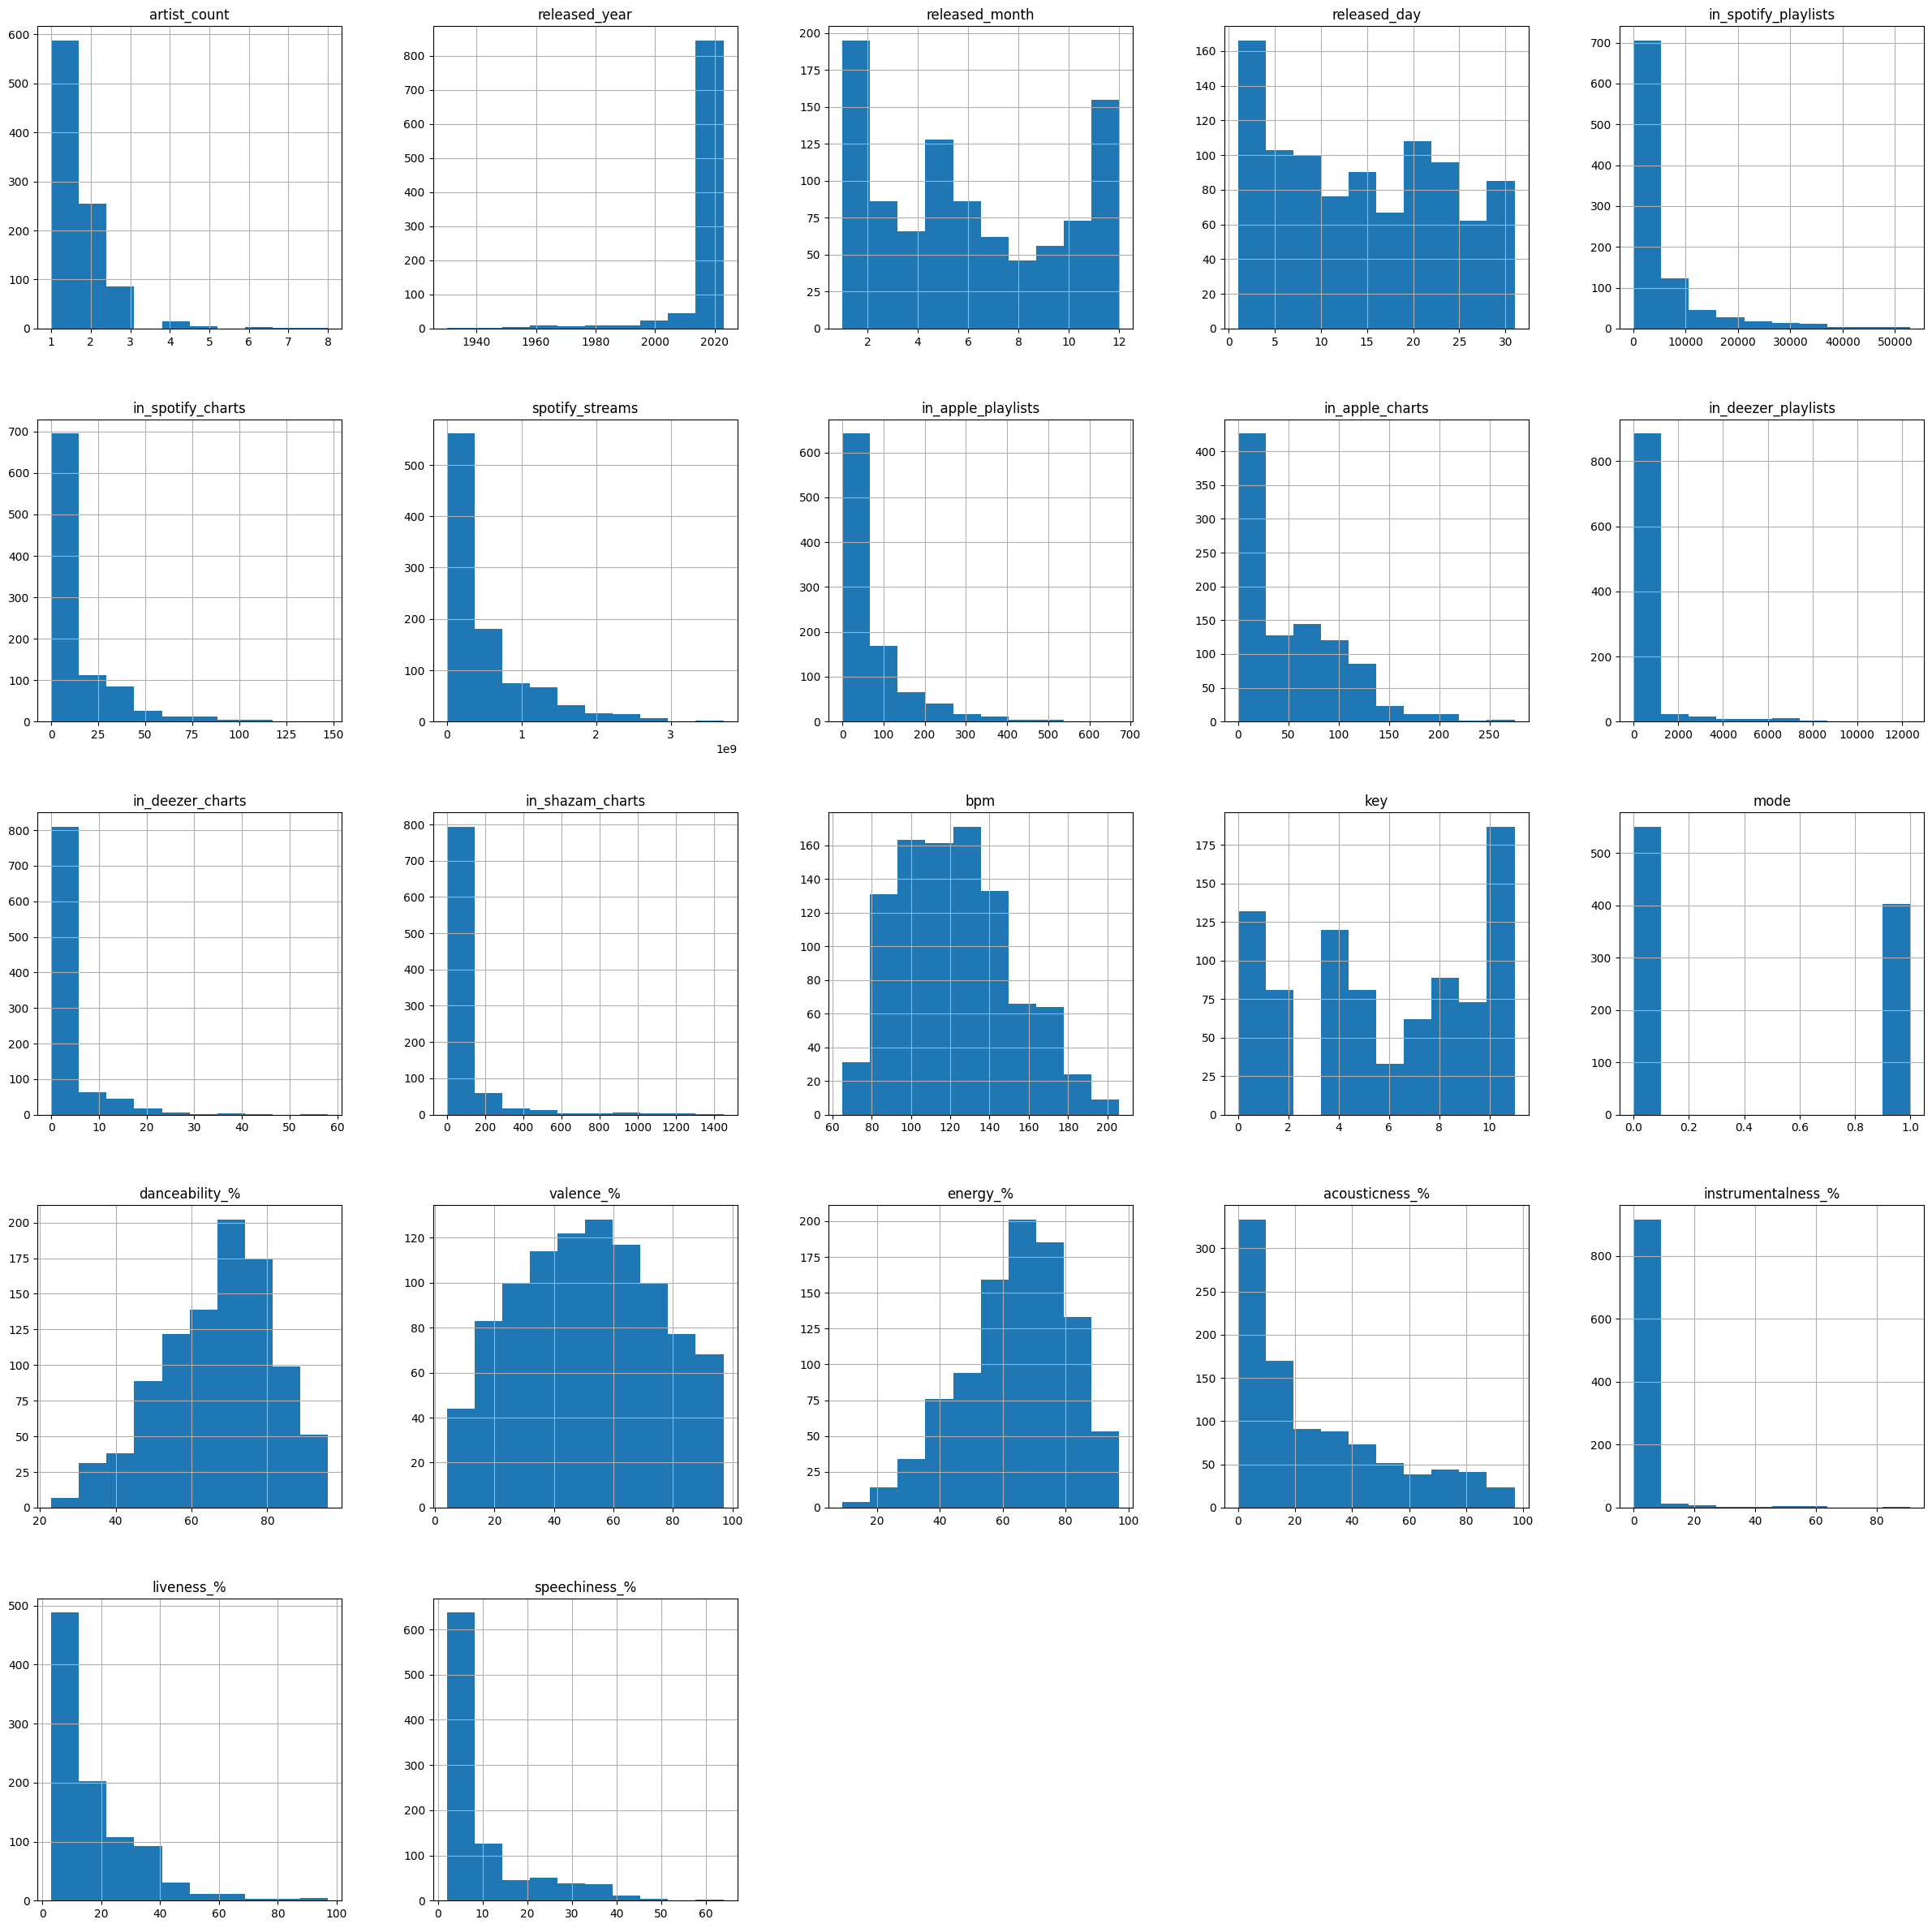

In [65]:
# Display histograms
df.hist(figsize=(30,30))
plt.show()

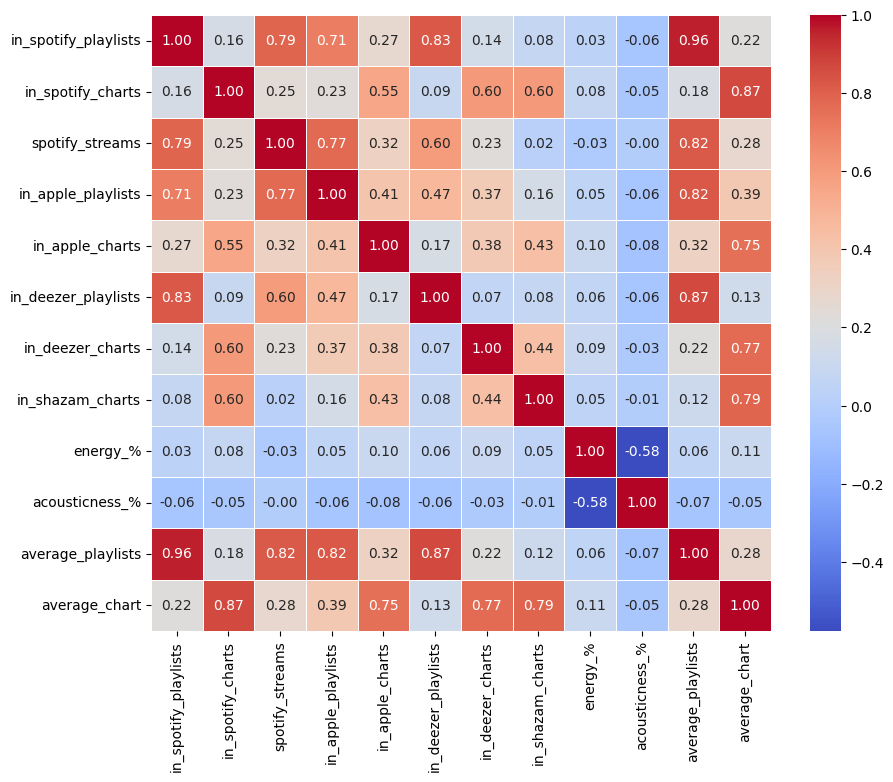

In [66]:
# Create categories to store average statistics
df['average_playlists'] = df[playlists_col].mean(axis=1)
df['average_chart'] = df[charts_col].mean(axis=1)

# Function to obtain a correlation matrix
def correlation_matrix():
    corr_matrix = df.select_dtypes(include = ['float64', 'int64']).corr()
    mask = np.abs(corr_matrix) >= 0.5
    np.fill_diagonal(mask.values, False)
    cols_to_keep = mask.any()
    cols_to_keep = cols_to_keep[cols_to_keep].index
    corr_filter = corr_matrix.loc[cols_to_keep, cols_to_keep]

    plt.figure(figsize=(10,8))
    sns.heatmap(corr_filter, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
    plt.show()

# Standardize data
scaler = StandardScaler()
df_n = pd.DataFrame(scaler.fit_transform(df.copy()), columns=df.columns, index=df.index)

# Display correlation matrix
df['average_playlists'] = df_n[playlists_col].mean(axis=1)
df['average_chart'] = df_n[charts_col].mean(axis=1)
correlation_matrix()

Clustering

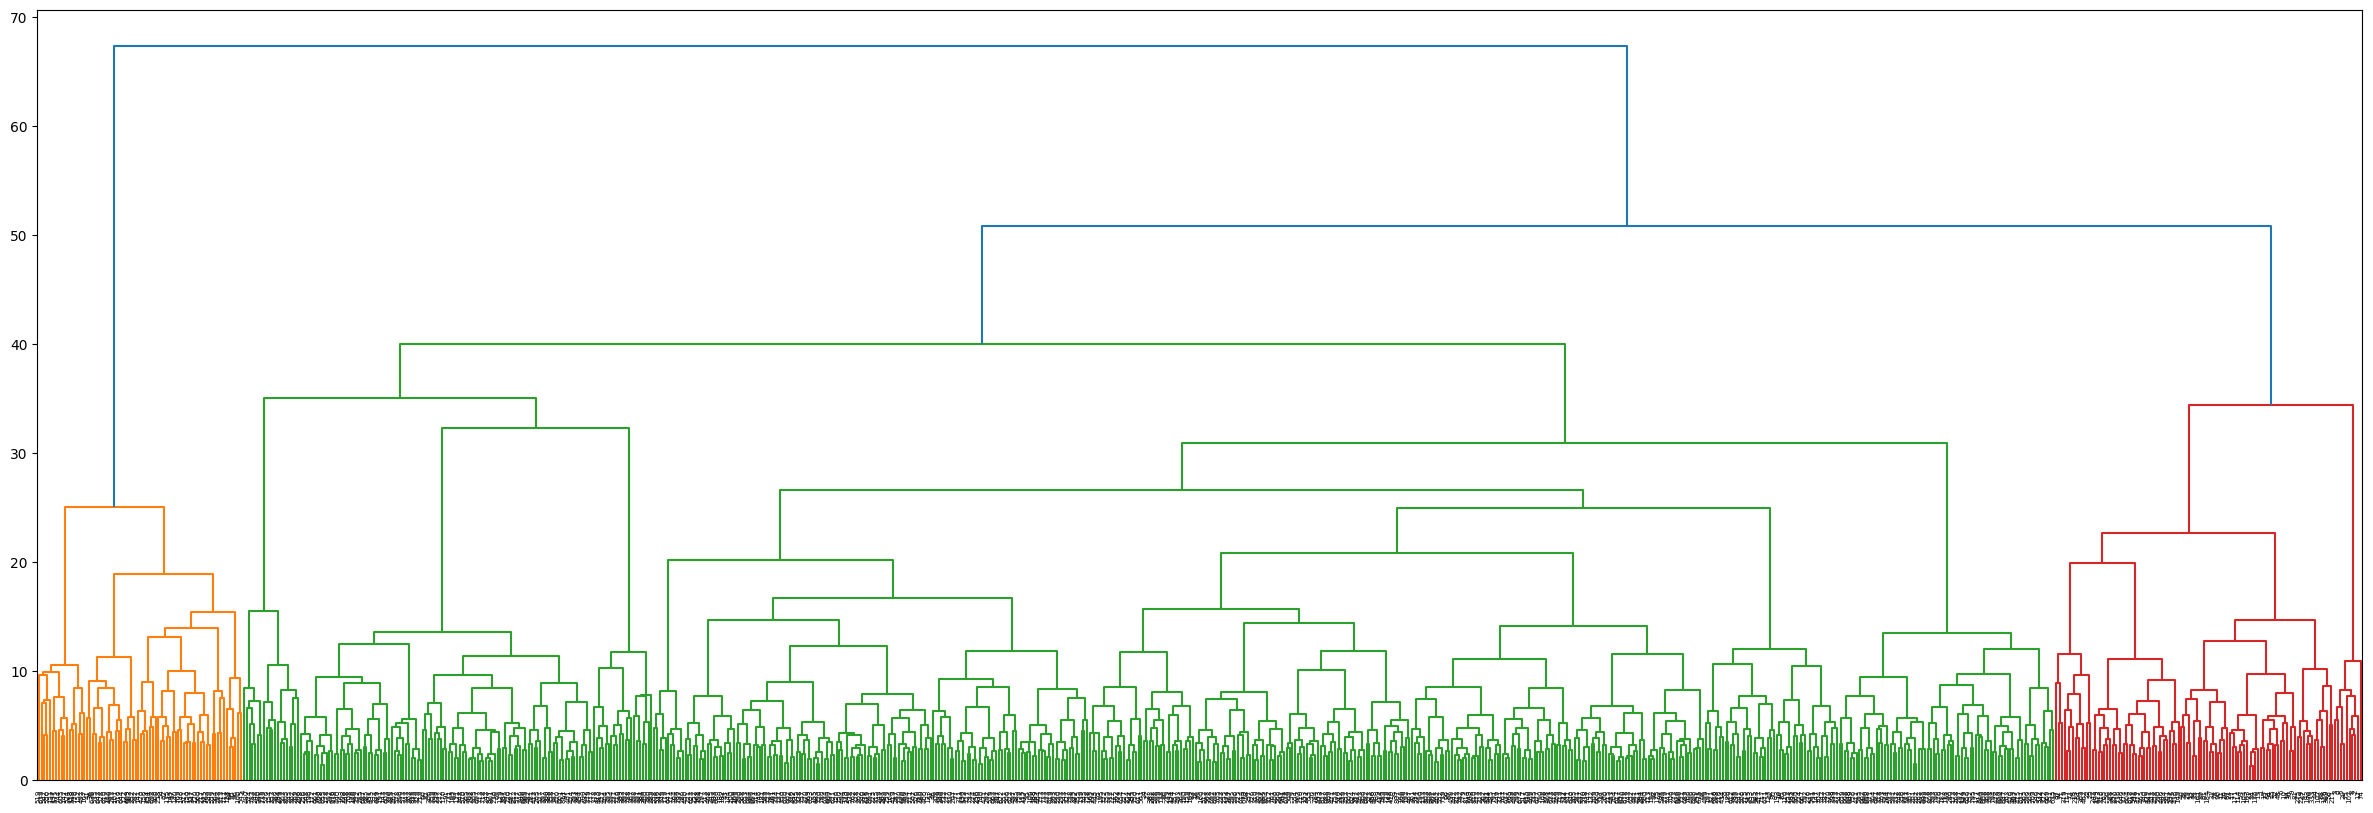

In [67]:
# Drop NaNs, indices
df_n.dropna(axis='rows', how='any', inplace=True)
df_n.reset_index(drop=True, inplace=True)

# Create dendrogram
Z = linkage(df_n, metric='euclidean', method='ward', optimal_ordering=True)
plt.figure(figsize=(30,10))
dendrogram(Z, labels=df_n.index)
plt.show()

K Clusters

In [68]:
# Use KMeans clustering approach
k_cluster = KMeans(n_clusters=3).fit_predict(df_n)
df_n["Cluster"] = k_cluster
df_n.groupby("Cluster").get_group(0).describe().loc[["mean", "50%", "max", "count"]]

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,spotify_streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,average_playlists,average_chart,Cluster
mean,-0.394022,-0.264655,0.234961,-0.077037,-0.259397,-0.368019,-0.263772,-0.343006,-0.357063,-0.251479,...,-0.828578,-0.723820,-0.785564,0.708173,0.339043,-0.070029,-0.266241,-0.265015,-0.322017,0.0
50%,-0.623072,0.338585,0.271119,-0.209929,-0.412002,-0.613800,-0.459769,-0.518683,-0.689845,-0.312572,...,-0.750162,-0.870590,-0.802759,0.729042,-0.188132,-0.453371,-0.517897,-0.411006,-0.495691,0.0
max,2.737988,0.428590,1.673816,1.855935,2.104383,1.737251,2.198236,2.363391,2.886970,0.718455,...,1.574953,1.899103,1.796709,2.537956,10.638259,4.727587,2.913782,1.902422,2.181344,0.0
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.0


In [69]:
df_n.groupby("Cluster").get_group(1).describe().loc[["mean", "50%", "max", "count"]]

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,spotify_streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,average_playlists,average_chart,Cluster
mean,-0.125137,-0.476469,-0.308142,-0.230064,1.777077,1.064778,1.541006,1.250301,0.865085,1.645665,...,-0.108729,-0.085054,0.124743,-0.146193,0.012357,-0.138514,-0.138469,1.795122,1.192393,1.0
50%,-0.623072,-0.246454,-0.430229,-0.536118,1.548480,0.740609,1.577880,0.899205,0.920710,0.808282,...,-0.203076,-0.124903,0.104032,-0.579534,-0.188132,-0.526342,-0.517897,1.560284,0.480728,1.0
max,1.617635,0.428590,1.673816,1.855935,6.042705,6.899341,5.380562,5.372785,4.171462,10.603915,...,1.916882,1.941713,1.978068,2.691907,7.307062,3.341134,3.418441,6.393813,7.735191,1.0
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.0


In [70]:
df_n.groupby("Cluster").get_group(2).describe().loc[["mean", "50%", "max", "count"]]

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,spotify_streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,average_playlists,average_chart,Cluster
mean,0.235170,0.272245,-0.044850,0.047150,-0.350963,-0.090216,-0.356337,-0.268331,-0.106372,-0.270463,...,0.461101,0.337594,0.345968,-0.344306,-0.141085,0.058334,0.223940,-0.347818,-0.149522,2.0
50%,0.497282,0.338585,-0.289959,-0.101200,-0.475853,-0.460471,-0.516676,-0.483959,-0.432947,-0.315227,...,0.549167,0.407730,0.406296,-0.541047,-0.188132,-0.380400,-0.316034,-0.468805,-0.320884,2.0
max,7.219402,0.428590,1.673816,1.855935,1.756754,4.548290,2.001297,2.166623,4.408599,1.140600,...,1.985267,1.941713,1.978068,2.153081,5.879406,5.749185,5.437076,1.702089,3.055375,2.0
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.0


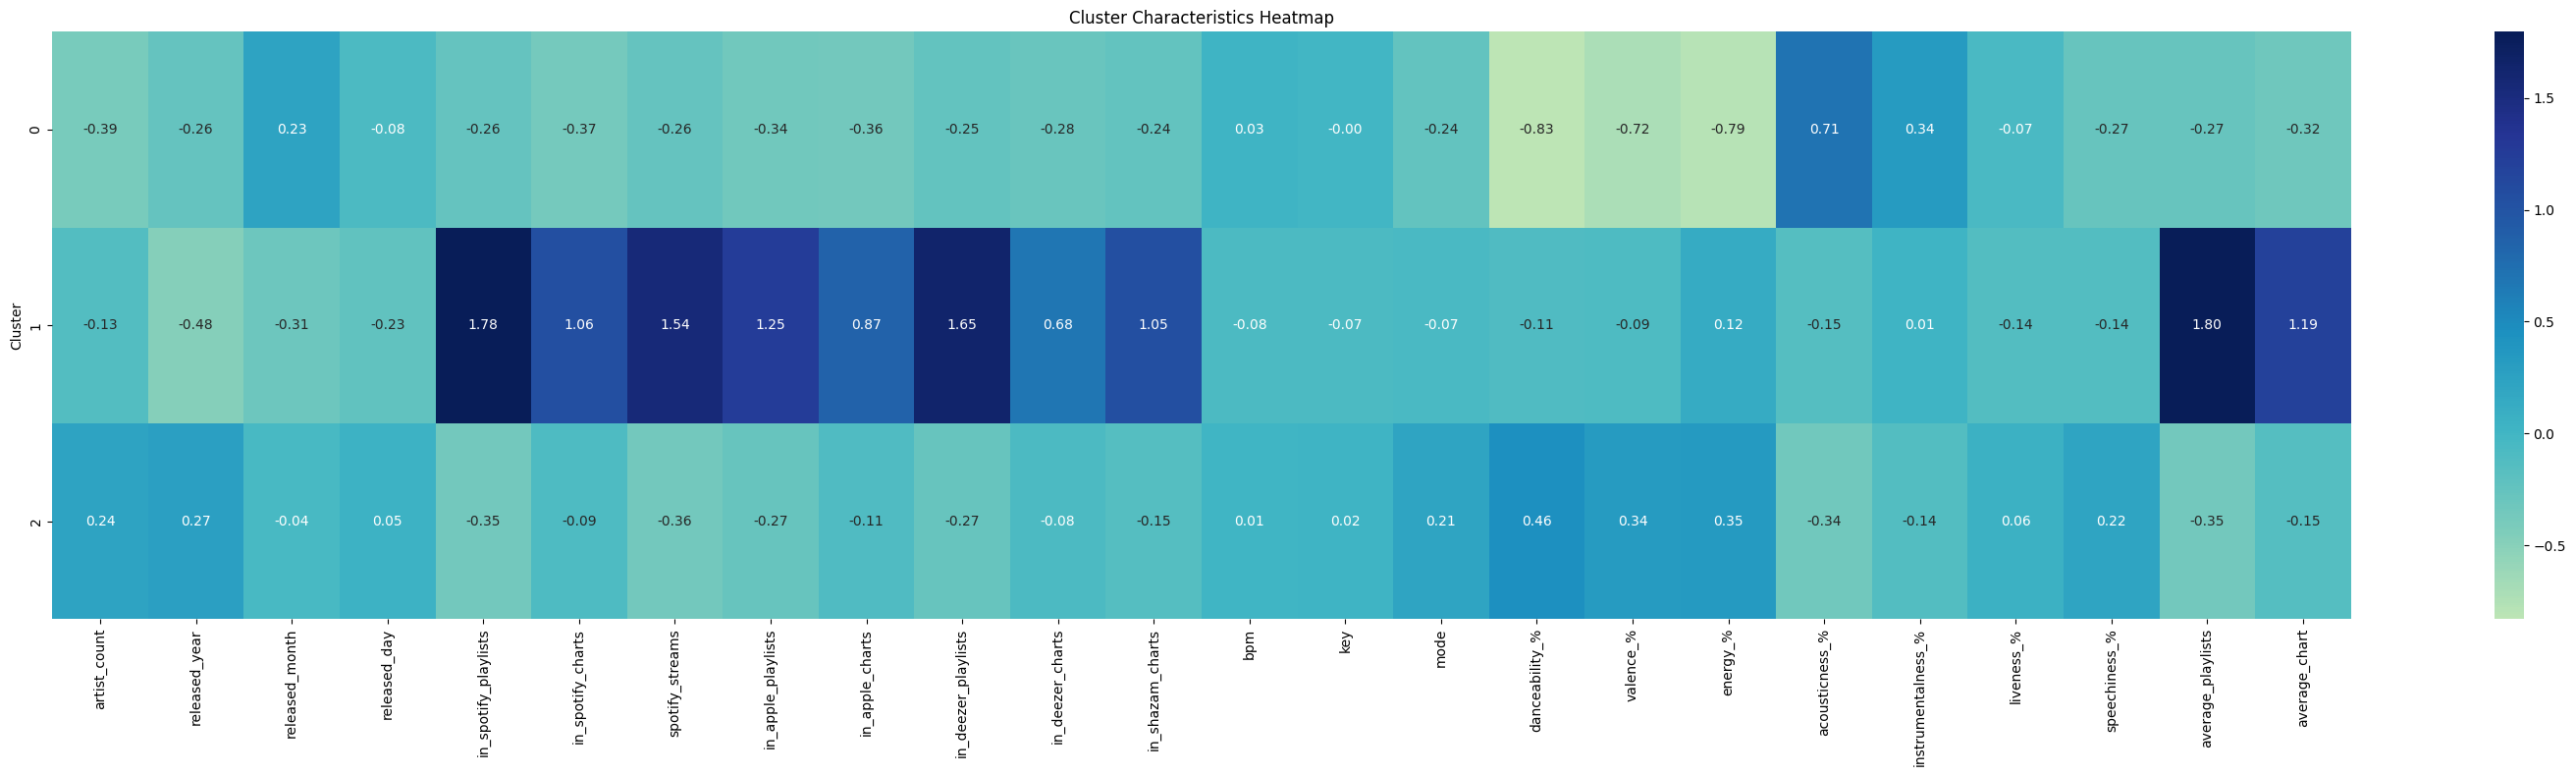

In [71]:
# Display heatmap to compare clusters
cluster_analysis = df_n.groupby("Cluster").mean()
plt.figure(figsize=(30,8))
sns.heatmap(cluster_analysis, annot=True, cmap='YlGnBu', fmt='.2F', center=0)
plt.title("Cluster Characteristics Heatmap")
plt.tight_layout()
plt.show()

Train Classifier

In [72]:
# Drop NaNs, indices
df.dropna(axis='rows', how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

# Split data into train, test
X_train, X_test, y_train, y_test = train_test_split(df, k_cluster, test_size=0.2, random_state=42)

# Classify model using Decision Tree
classifier = DecisionTreeClassifier(random_state=42, max_depth=6)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71        43
           1       0.76      0.90      0.83        21
           2       0.88      0.85      0.86       100

    accuracy                           0.82       164
   macro avg       0.78      0.82      0.80       164
weighted avg       0.82      0.82      0.82       164



In [73]:
# Classify model using Random Forest
classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        43
           1       0.86      0.90      0.88        21
           2       0.92      0.97      0.94       100

    accuracy                           0.91       164
   macro avg       0.91      0.89      0.90       164
weighted avg       0.92      0.91      0.91       164

